## Step 0: Load necessary modules and functions

In [21]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys, os, subprocess, glob, shutil
import cartopy
import cartopy.crs as ccrs
from pyproj import CRS
from datetime import datetime, timedelta
import xarray as xr
import pandas as pd
from scipy import stats

### It can be useful to estimate the area of each grid cell as well as the distance between two of them. Let's assume Earth is a sphere and grid cells are rectangulars.
def distance_on_unit_sphere(lat1, long1, lat2, long2):
    # Convert latitude and longitude to spherical coordinates in radians
    degrees_to_radians = np.pi / 180.0
    phi1 = (90.0 - lat1) * degrees_to_radians
    phi2 = (90.0 - lat2) * degrees_to_radians
    theta1 = long1 * degrees_to_radians
    theta2 = long2 * degrees_to_radians
    # Compute spherical distance
    cos = (np.sin(phi1) * np.sin(phi2) * np.cos(theta1 - theta2) +
           np.cos(phi1) * np.cos(phi2))
    arc = np.arccos(np.clip(cos, -1.0, 1.0))  # Clip to avoid numerical issues

    return arc

def compute_area(lons_nxsim, lats_nxsim):
    nx = lons_nxsim.shape[1]
    ny = lons_nxsim.shape[0]
    dx = np.zeros_like(lons_nxsim)
    dy = np.zeros_like(lons_nxsim)

    R = 6370997  # Earth radius in meters

    # Compute dx (north-south distances)
    dx[:-1, :] = distance_on_unit_sphere(
        lats_nxsim[:-1, :], lons_nxsim[:-1, :],
        lats_nxsim[1:, :], lons_nxsim[1:, :]
    ) * R

    # Compute dy (east-west distances)
    dy[:, :-1] = distance_on_unit_sphere(
        lats_nxsim[:, :-1], lons_nxsim[:, :-1],
        lats_nxsim[:, 1:], lons_nxsim[:, 1:]
    ) * R

    # Fill last row and column
    dx[-1, :] = dx[-2, :]
    dy[:, -1] = dy[:, -2]

    # Compute area
    area = dx * dy
    return area


# NeXtSIM-WAVEWATCH III

neXtSIM-WAVEWATCH III is a coupled modelling system that combines the sea ice model neXtSIM with the spectral wave model WAVEWATCH III. Developed at NERSC, it has been used to study wave-ice interactions in the MIZ [1, 2], with a particular focus on the impact of wave-induced ice breakup on sea ice dynamics [1].

### Brief description of the system

In short, WAVEWATCH III (hereafter WW3) simulates the generation, propagation and dissipation of wave "energy", while neXtSIM estimates the evolution of sea ice through dynamic and thermodynamic processes. Sea ice attenuates waves. This attenuation is estimated in WW3, based on sea ice properties (concentration, thickness, and characteristic floe sizes) sent by neXtSIM. In turn, waves can break the sea ice. This depends on the amount of flexural strain exerted by the waves on sea ice. WW3 computes this strain and sends the wavelength associated with the shortest waves that can break the ice to neXtSIM. neXtSIM uses this information to redistribute its areal floe size distribution (FSD), which represents the subgrid distribution of floe sizes covering each element of the mesh. This FSD can then be used for various processes, like lateral melting, or to recompute characteristic floe sizes, that will in turn impact the wave attenuation. The coupling is summarized in Figure 1 below.

### What with the data we provide here?

In the simulation provided here, the coupling is similar to [2] and is "simpler" than in [1]: the FSD is not associated with any processes impacting sea ice dynamics or thermodynamics. Therefore, the wave state has no impact on the evolution of sea ice volume or area. It is still interesting though! Wave-induced breakup has a rapid feedback on wave attenuation, and waves can propagate further in broken ice than in unbroken ice. neXtSIM is therefore used to represent the evolution (advection, "healing") of broken floes. I'll try to show you what we can do with that.

Note: The tutorial includes data for 2021 only, but years 2018-->2022 are available in the extra-data repository.

******
_References_:

[1] Boutin, G., Williams, T., Rampal, P., Olason, E., & Lique, C. (2021). Wave–sea-ice interactions in a brittle rheological framework. The Cryosphere, 15(1), 431–457. https://doi.org/10.5194/tc-15-431-2021

[2] Boutin, G., Williams, T., Horvat, C., & Brodeau, L. (2022). Modelling the Arctic wave-affected marginal ice zone: A comparison with ICESat-2 observations. Philosophical Transactions of the Royal Society A: Mathematical, Physical and Engineering Sciences, 380(2235), 20210262. https://doi.org/10.1098/rsta.2021.0262




![title](Supporting_material_WW3-neXtSIM/WW3-neXtSIM_schematic.png)

#### Figure 1: Description of the coupling system.


Note that WAVEWATCH III is a spectral wave model. If you are not familiar with the concept, the wave spectrum is a representation of wave energy over different frequencies and direction. Thus, unlike ocean or sea ice models, that simulate the evolution of the ocean or sea ice flow by solving Navier-Stokes equations, the wave model represents the evolution of this spectrum due to sources (the wind), advection, redistribution of energy between direction and frequencies (due to refraction, shoaling, non-linear interactions...) and sinks (like wave breaking, or ice!). Spectral wave models do not deal with individual waves, instead the wave spectrum gives statistical informations about the sea state. This means that information like wave height and period can be derived from the spectrum, as integrated parameters, often computed usings different moments of the distributions (see some examples in the WW3 section further down).

## Path to model outputs

Note that neXtSIM uses 1 file per month for all variables, while WW3 has 1 file per month *and* per variable (so that's a lot more files). There is no particular good reason for that, just linked to an old workflow system I haven't changed for years. One advantage is that ww3 files are a bit lighter and easier to share, and xarray makes it not too cumbersome to load multiple files at the same time.

In [3]:
path_nextsim_outputs = "/home/nextsim-workshop/data-nextsim-workshop2025/ww3-nextsim/analysis/nextsim_outputs"
path_ww3_outputs     = "/home/nextsim-workshop/data-nextsim-workshop2025/ww3-nextsim/analysis/ww3_outputs"

nextsim_file_format  = f"{path_nextsim_outputs}/%Y/Moorings_%Ym%m.nc" ## One file per month contains all variables
ww3_file_format      = f"{path_ww3_outputs}/%Y/ww3.%Y%m_*.nc" ### One file per variable AND per month 
##(This could be changed, but I started like this in my PhD and I am used to it in my workflow, sorry)

## Reading into neXtSIM outputs

In [4]:
### Pick your favourite year/month (among what is available)
date = datetime(2021,3,1) 

### The name of the corresponding file
nextsim_file = date.strftime(nextsim_file_format)
print(f"\nWe are looking for {nextsim_file}.\n\n\n")

### We could check whether it exists first, but the error in open_dataset would tell us if this is not the case anyway.
ds_nxm = xr.open_dataset(nextsim_file)
print(ds_nxm)

grid_area=compute_area(ds_nxm["longitude"],ds_nxm["latitude"]) / 1e6 #converting to km2
# Ensure grid_area is an xarray DataArray with matching dimensions
grid_area_da = xr.DataArray(grid_area, coords={"y": ds_nxm.y, "x": ds_nxm.x}, dims=("y", "x"))


We are looking for /home/nextsim-workshop/data-nextsim-workshop2025/ww3-nextsim/analysis/nextsim_outputs/2021/Moorings_2021m03.nc.



<xarray.Dataset>
Dimensions:     (time: 248, y: 448, x: 304, nv: 2)
Coordinates:
    latitude    (y, x) float32 ...
    longitude   (y, x) float32 ...
  * time        (time) datetime64[ns] 2021-03-01 ... 2021-03-31T21:00:00
Dimensions without coordinates: y, x, nv
Data variables: (12/16)
    dmax        (time, y, x) float32 ...
    dmean       (time, y, x) float32 ...
    dvi_thermo  (time, y, x) float32 ...
    sic         (time, y, x) float32 ...
    sic_young   (time, y, x) float32 ...
    sit         (time, y, x) float32 ...
    ...          ...
    sss         (time, y, x) float32 ...
    sst         (time, y, x) float32 ...
    t2m         (time, y, x) float32 ...
    taux        (time, y, x) float32 ...
    tauy        (time, y, x) float32 ...
    time_bnds   (time, nv) datetime64[ns] ...
Attributes:
    Conventions:  CF-1.6
    institution:  NER

# What can we do with neXtSIM?

### A quick example: Computing a "lead fraction"

The lead fraction is the fraction occupied by sea ice leads. It depends on the definition, but we can consider leads as openings in the sea ice. Openings mean that leads are either open water, or very thin, unconsolidated sea ice. The open water fraction can be computed as $1-\rm sic$, "sic" being the total sea ice concentration. 

Additionally, the lead fraction can be defined as $1-(\rm sic-sic_{young})$. But what is $\rm sic_{young}$?

neXtSIM includes two sea ice categories, the "young" ice and the "consolidated" ice. "Young" ice is ice that grows in open water until it reaches a thickness threshold (generally around 20/30cm). This threshold is a model parameter. Consolidated ice is, well, all the rest. "Young" ice is generally found in marginal ice zones, leads and polynyas. Therefore, "sic_young" is the fraction occupied by young ice. The fraction occupied by consolidated ice can be derived as $\rm (sic-sic_{young})$. If we consider that leads are not just open water, but also include young ice that has not yet been consolidated, the lead fraction should be equal to $1- \rm sic_{consolidated}=1-(sic-sic_{young})$.  

This definition works well in a domain away from shelves and MIZs, in winter, as it will definitely highlight leads. But close to the ice edge, it will also include the MIZ, and does not differentiate between leads and polynyas. 

In [5]:
ds_nxm['sic_consolidated'] = ds_nxm["sic"]-ds_nxm["sic_young"]
## Computing the lead fraction
ds_nxm['lead_frac'] = 1-ds_nxm['sic_consolidated']
ds_nxm['lead_frac'] = ds_nxm['lead_frac'].where(ds_nxm['sic_consolidated']>=.15,np.nan)

### The conservative version, we ignore young ice, leads are only open water.
if 0:
    ds_nxm['lead_frac_conservative'] = 1-ds_nxm["sic"]
    ds_nxm['lead_frac_conservative'] = ds_nxm['lead_frac_conservative'].where(ds_nxm["sic"]>=.15,np.nan)


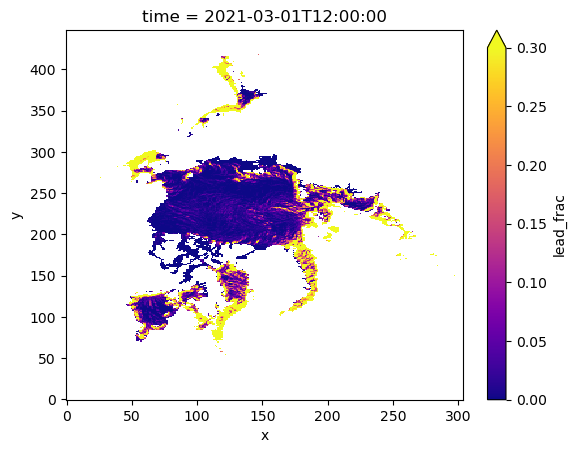

In [6]:
### Example of how to do a quick and dirty plot with xarray and neXtSIM outputs
ds_nxm['lead_frac'].isel(time=4).plot(cmap="plasma",vmin=0,vmax=0.3)
### You could try computing 'lead_frac_conservative' and check how it looks like!

In [7]:
#### This is the actual projection of the grid (NSIDC)
#### We can use this information later to plot fancier maps. The fancier the map, the easier the review process.

# Create a Cartopy Stereographic projection with your custom parameters
proj = ccrs.Stereographic(
    central_latitude=90.0,
    central_longitude=-45.0,
    true_scale_latitude=60.0,
    globe=ccrs.Globe(semimajor_axis=6378273.0, semiminor_axis=6356889.448910593)
)
## And two functions to make plots look a bit nicer
def format_fancy_map(ax):
    ax.coastlines(lw=0.2) 
    ax.set_extent([0,360,60,90], crs=ccrs.PlateCarree())
    ax.gridlines(lw=0.1)
    
def format_timeseries():
    plt.grid(ls="--",lw=0.25)
    plt.legend()



 You find the hexagon feature in the contour plot annoying? Me too.
 I have  a trick to get rid of it.
 I've hidden some lines in this cell that may do the trick...


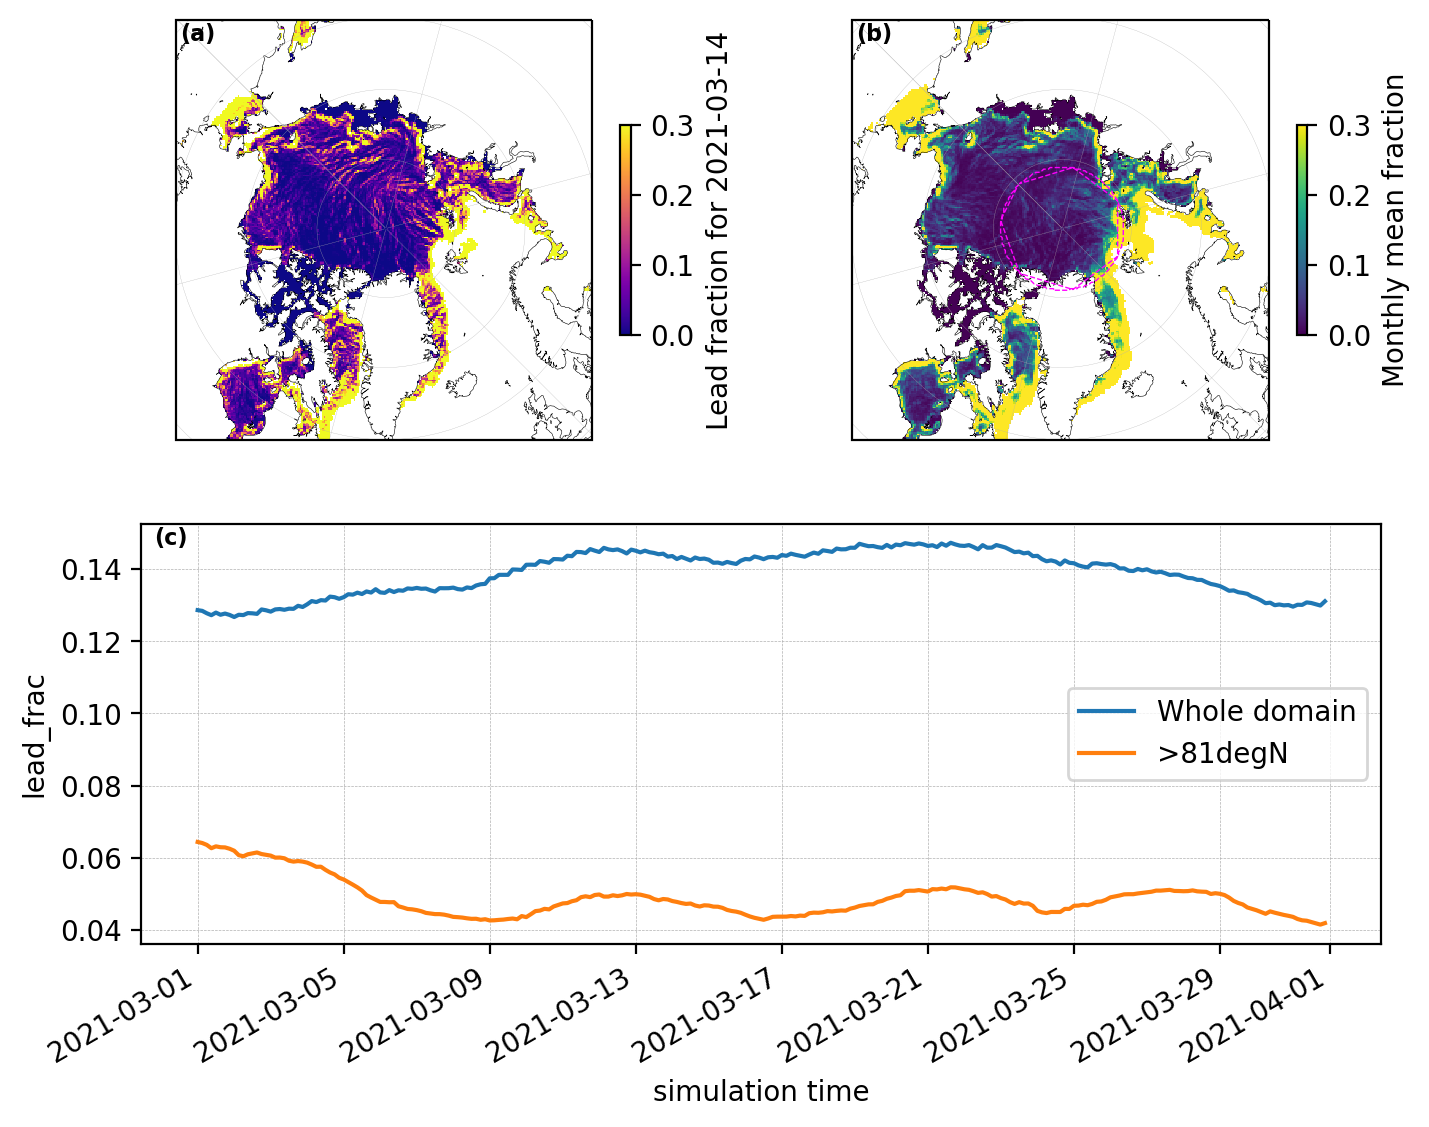

In [26]:
### Making a fancier figure with a proper projection etc.


### Let's define a box for fun
inner_Arctic=xr.where(ds_nxm['latitude']>=81,1,0)


if 0: ### If 1: --> Does not trust matplotlib/cartopy to reproject coordinates properly and do some interpolation when plotting contours
    transformed_coor=proj.transform_points(ccrs.PlateCarree(),ds_nxm['longitude'].values,ds_nxm['latitude'].values)
    x_ster,y_ster=transformed_coor[:,:,0],transformed_coor[:,:,1]
    use_transformed_coordinates_directly = True
else : 
    use_transformed_coordinates_directly = False ##Otherwise, let's trust matplotlib/cartopy ability to do contour plots on a projection properly

### What date are we plotting?
time_sel="2021-03-14T00:00:00"

fig=plt.figure(figsize=(8,6),dpi=200)

### Plot the selected snapshot 
ax=fig.add_subplot(221,projection=proj)
im=ax.pcolormesh(ds_nxm['longitude'],ds_nxm['latitude'],ds_nxm['lead_frac'].sel(time=time_sel),
              transform=ccrs.PlateCarree(),cmap="plasma",vmin=0,vmax=0.3)
cb=fig.colorbar(im, orientation='vertical',shrink=0.5)
cb.set_label(f"Lead fraction for {time_sel[:10]}")
format_fancy_map(ax)
plt.text(0.01,0.95,"(a)", fontsize=8,weight="bold",transform=ax.transAxes,color="k")

### Plot the monthly mean
ax=fig.add_subplot(222,projection=proj)

im=ax.pcolormesh(ds_nxm['longitude'],ds_nxm['latitude'],ds_nxm['lead_frac'].mean(dim="time"),
              transform=ccrs.PlateCarree(),cmap="viridis",vmin=0,vmax=0.3)
cb=fig.colorbar(im, orientation='vertical',shrink=0.5)
cb.set_label(f"Monthly mean fraction")
format_fancy_map(ax)

### Add a contour to represent the box of interest
if use_transformed_coordinates_directly:
    ax.contour(x_ster,y_ster,inner_Arctic,levels=[0.9],linestyles="--",colors="magenta",linewidths=0.5)
else :
    ax.contour(ds_nxm['longitude'],ds_nxm['latitude'],inner_Arctic,levels=[0.9],transform=ccrs.PlateCarree(),
                linestyles="--",colors="magenta",linewidths=0.5)
plt.text(0.01,0.95,"(b)", fontsize=8,weight="bold",transform=ax.transAxes,color="k")


### Investigate the temporal evolution of the mean lead fraction
ax=fig.add_subplot(212)
ds_nxm['lead_frac'].mean(dim=("x","y"),skipna=None).plot(label="Whole domain")
ds_nxm['lead_frac'].where(inner_Arctic).mean(dim=("x","y"),skipna=None).plot(label=">81degN")
format_timeseries()
plt.text(0.01,0.95,"(c)", fontsize=8,weight="bold",transform=ax.transAxes,color="k")


print("\n You find the hexagon feature in the contour plot annoying? Me too.\n I have  a trick to get rid of it.\n I've hidden some lines in this cell that may do the trick...")

##### Technically, we should use a weighted average to account for area differences between grid cells.

## Defining the marginal ice zone (MIZ) using sea ice concentration.

The main motivation behind neXtSIM-WW3 and wave-ice coupling in general is to study what's going on in the marginal ice zone.

The marginal ice zone definition is somewhat of a blurry thing. Qualitatively, it generally carries the idea of a region that is ice-covered (partially or totally), but where processes associated with atmosphere--ocean interactions in open ocean are still occurring. It is distinct from pack ice, where the ocean surface fluxes (heat, light, momentum) are greatly reduced by the presence of ice. Therefore, the MIZ is characterized by a high hetereogeneity and a large number of air-sea interactions going on, modulated by the high variability in sea ice properties.


**Now, in practice, how do quantitatively define the MIZ?**

A standard criterion uses the sea ice concentration. Strong and Rigor (2013) used 15%--80% as the lower and upper limit of sea ice concentration in the MIZ. Therefore, defining a cMIZ (concentration-based MIZ) is not so different from computing a lead fraction.

Text(0, 0.5, 'MIZ extent [km$^2$]')

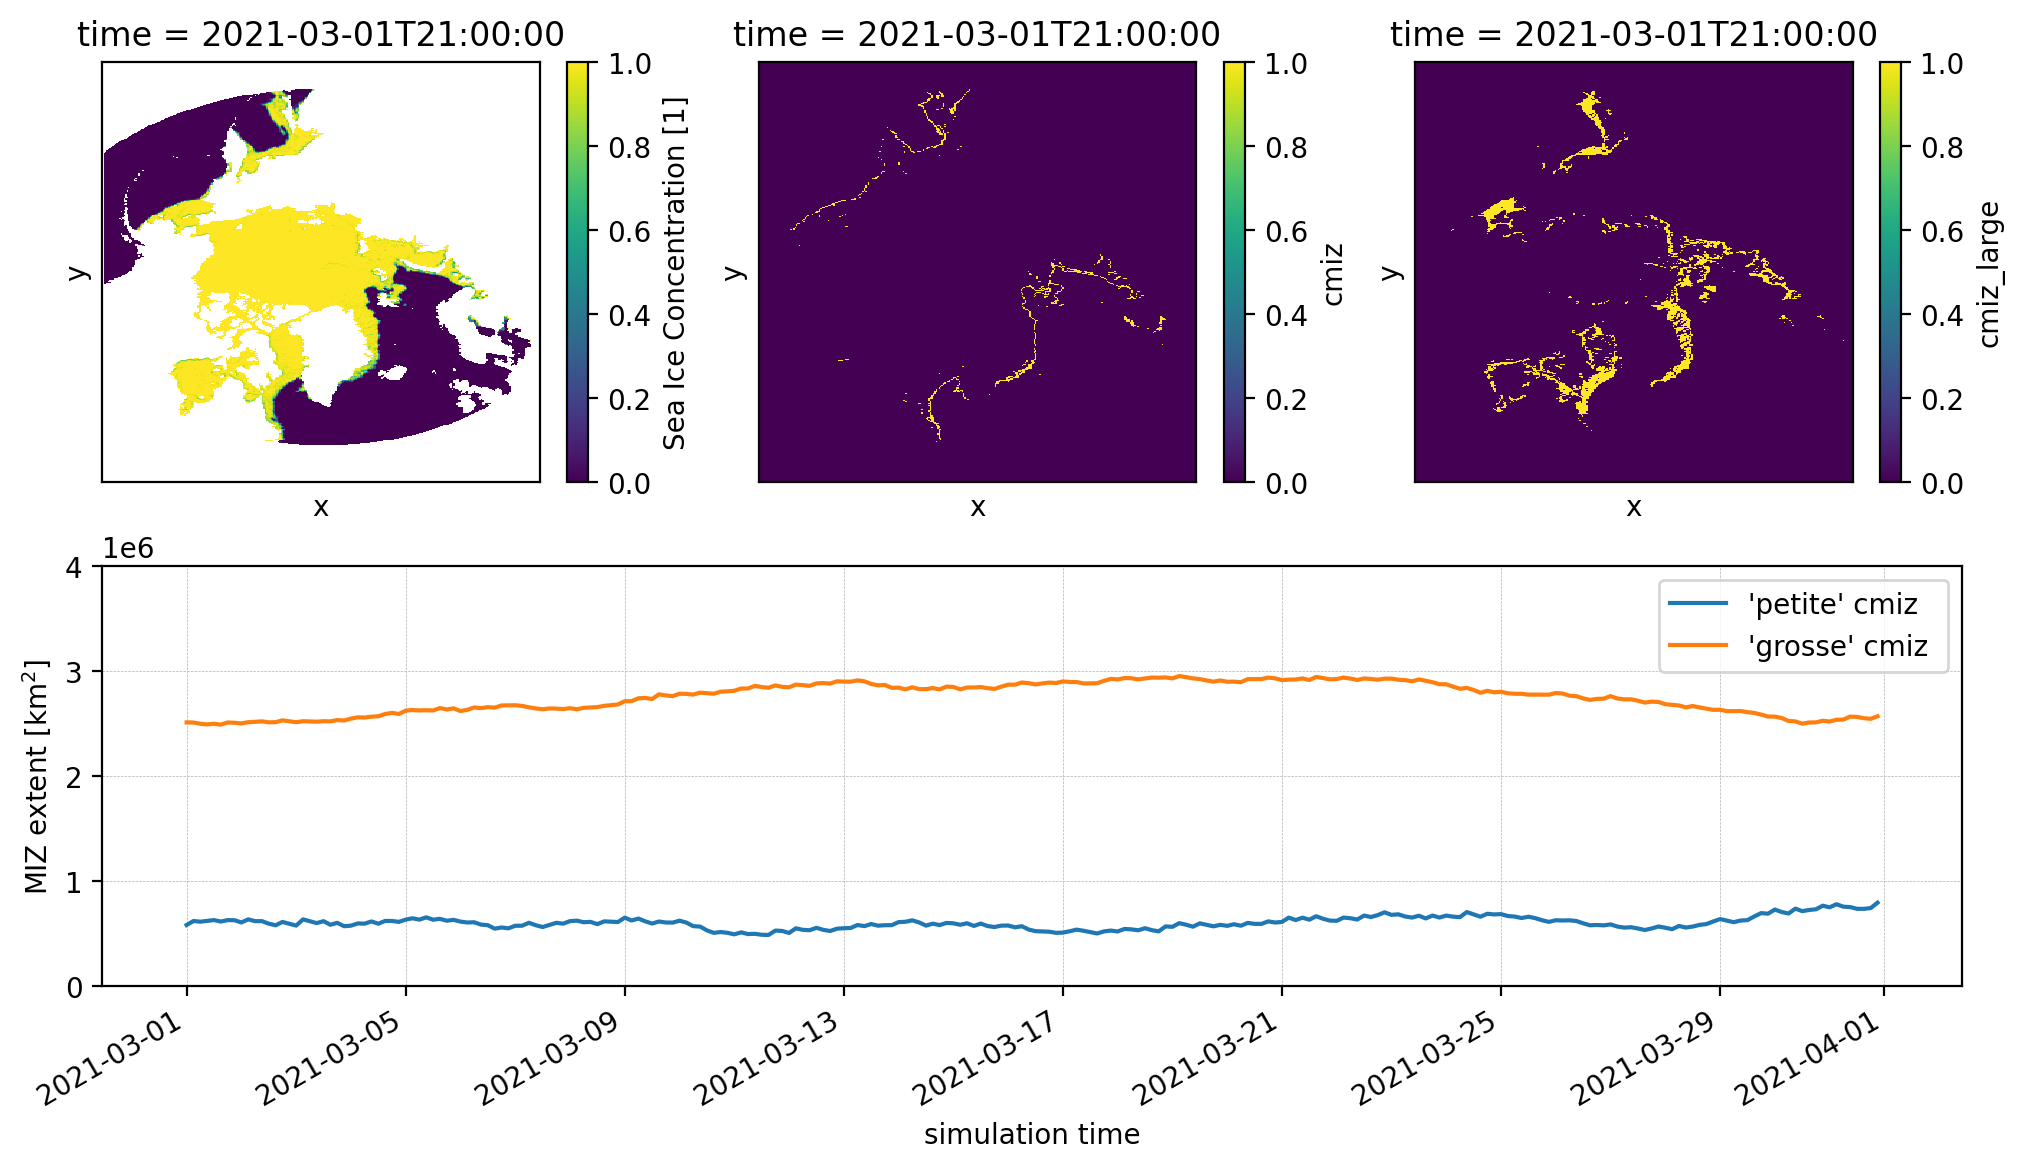

In [27]:
##### Let's have a look at the cMIZ!

### A quick function to have cleaner "quick and dirty maps"
def format_map(ax):
    plt.xticks([])
    plt.yticks([])


### We define the cMIZ as suggested by Strong and Rigor (2013)
ds_nxm["cmiz"]=xr.where( (ds_nxm['sic']<.8) & (ds_nxm['sic']>=.15),1,0)
### But like for the lead fraction, we can hesitate, which concentration to use? 
### In compact young ice, air-sea interactions should not be totally impeded by the ice cover
ds_nxm["cmiz_large"]=xr.where( (ds_nxm['sic_consolidated']<.8) & (ds_nxm['sic_consolidated']>=.15),1,0)

tt = 7 #time index
fig=plt.figure(figsize=(12,6),dpi=200)

ax=fig.add_subplot(231)
ds_nxm["sic"].isel(time=tt).plot()
format_map(ax)

ax=fig.add_subplot(232)
ds_nxm["cmiz"].isel(time=tt).plot()
format_map(ax)

ax=fig.add_subplot(233)
ds_nxm["cmiz_large"].isel(time=tt).plot()
format_map(ax)


###
ax=fig.add_subplot(212)

# Area-weighted sum of cmiz-es
cmiz_area_sum = (ds_nxm["cmiz"] * grid_area_da).sum(dim=("x", "y"))
cmiz_area_sum.plot(ax=ax, label="'petite' cmiz ")

cmiz_large_area_sum = (ds_nxm["cmiz_large"] * grid_area_da).sum(dim=("x", "y"))
cmiz_large_area_sum.plot(ax=ax, label="'grosse' cmiz ")

format_timeseries()
plt.ylim([0,4e6])
plt.ylabel(r"MIZ extent [km$^2$]")

The concentration criterion is a bit arbitrary... If we consider the total concentration, then the MIZ is limited to the very outer end of the ice edge. If you distinguish young ice (that is thin and has no internal stress) from consolidated ice, leads and polynyas are also included. Basically, the 0.15-->0.8 concentration criterion works pretty well to define the MIZ only when leads and polynyas are not resolved. Or maybe they should be considered MIZ?


### Define a floe size MIZ


Ok, so we have talked about the cMIZ, but we have outputs from a **coupled** wave--sea-ice system... Waves can break the sea ice. In the neXtSIM outputs, we can find some information about floe-size parameters. These are: 
- the mean floe size, characteristic of the average size of floes that occupy a significant fraction of the cell area
- the maximum floe size, characteristic of the biggest floes in the grid cell

For details, see:
Boutin, G., Williams, T., Rampal, P., Olason, E., & Lique, C. (2021). Wave–sea-ice interactions in a brittle rheological framework. The Cryosphere, 15(1), 431–457. https://doi.org/10.5194/tc-15-431-2021




### Which floe size should we use as a threshold?

Let's try a few different ones, using _dmax_, the maximum floe size and thresholds of 50, 100 and 500 metres. These are typical floe sizes associated with wave-induced sea-ice breakup.

In [28]:
### Like for the cMIZ, we define the MIZ "masks"
ds_nxm["dmiz_100"]= xr.where( (ds_nxm['dmax']<=100) & (ds_nxm['sic']>=.15), 1, 0)
ds_nxm["dmiz_500"]= xr.where( (ds_nxm['dmax']<=500) & (ds_nxm['sic']>=.15), 1, 0)
ds_nxm["dmiz_50"] = xr.where( (ds_nxm['dmax']<=50) & (ds_nxm['sic']>=.15), 1, 0)

Text(0, 0.5, 'dMIZ extent [Mkm$^2$]')

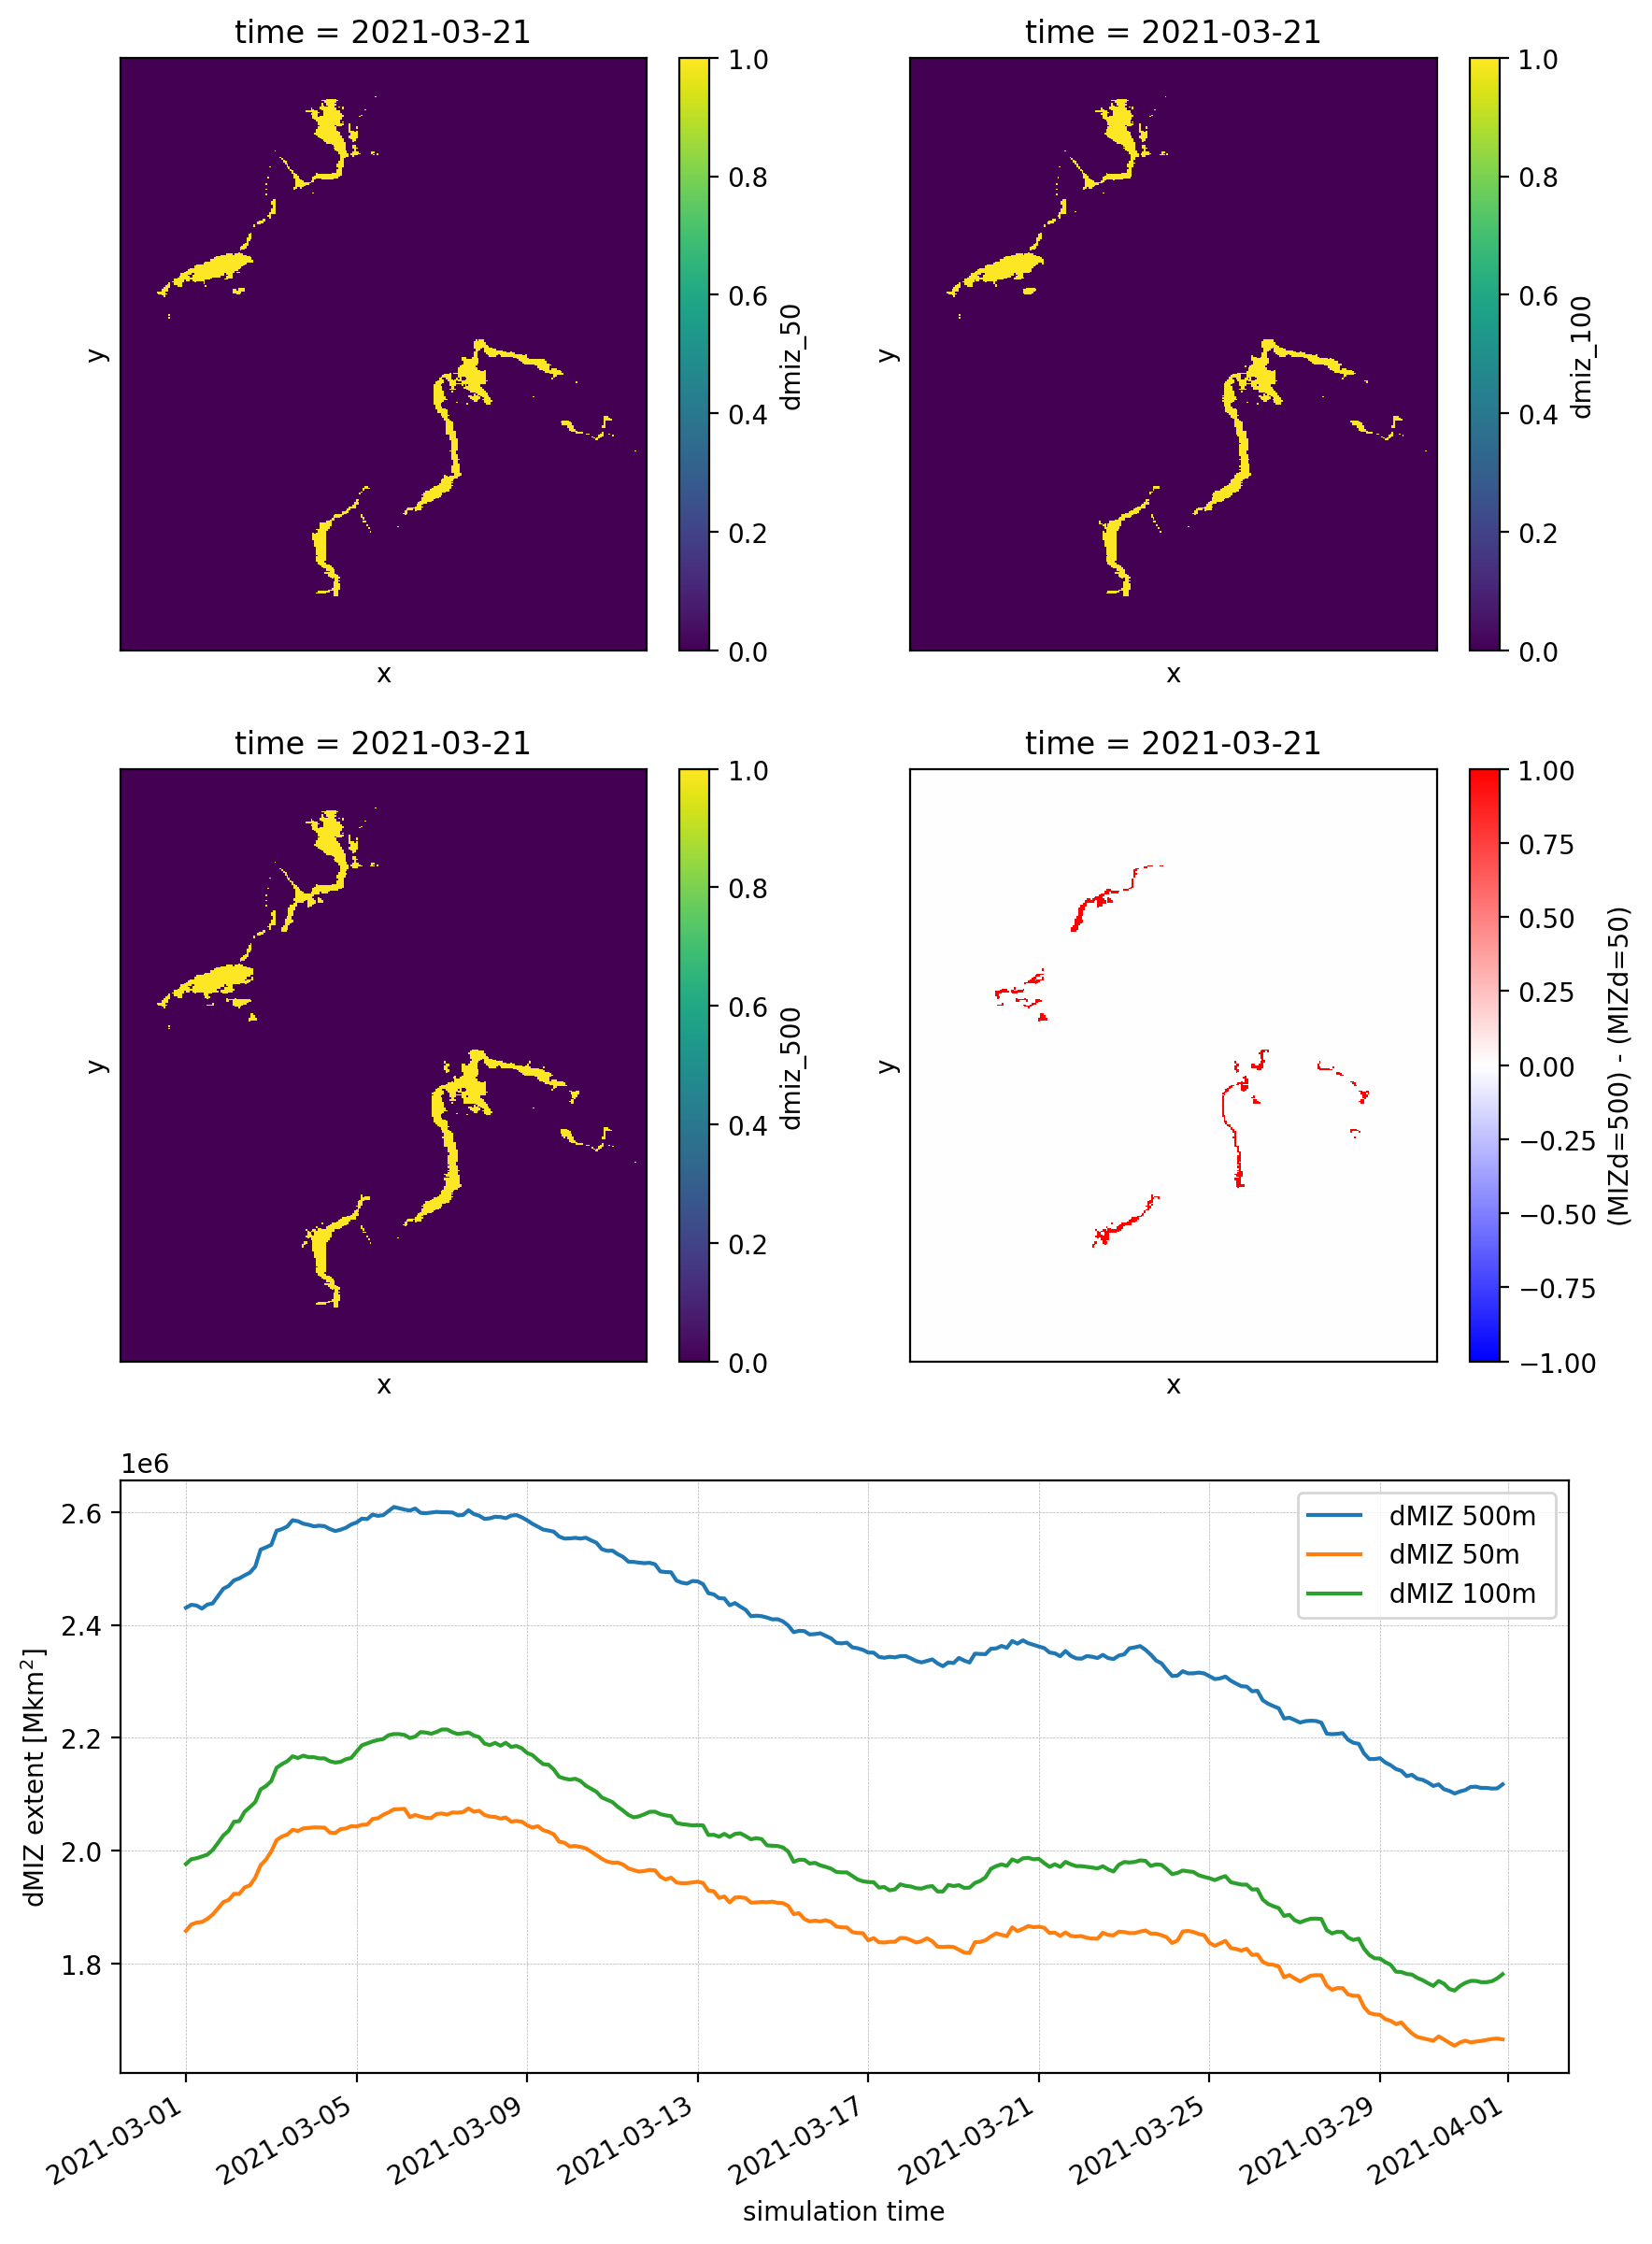

In [39]:
### More quick and dirty plots

sel_time='2021-03-21T00:00:00'

fig=plt.figure(figsize=(10,14),dpi=200)

ax=fig.add_subplot(321)
ds_nxm["dmiz_50"].sel(time=sel_time).plot()
format_map(ax)

ax=fig.add_subplot(322)
ds_nxm["dmiz_100"].sel(time=sel_time).plot()
format_map(ax)

ax=fig.add_subplot(323)
ds_nxm["dmiz_500"].sel(time=sel_time).plot()
format_map(ax)

### Plot the difference between using the 500m and 50m threshold
ax=fig.add_subplot(324)
cs= (ds_nxm["dmiz_500"]-ds_nxm["dmiz_50"]).sel(time=sel_time).plot(cmap="bwr",vmin=-1,vmax=1,label="Diff MIZ500-MIZ50")
format_map(ax)
cs.colorbar.set_label("(MIZd=500) - (MIZd=50)")
ax=fig.add_subplot(313)
dmiz_500_area_sum = (ds_nxm["dmiz_500"] * grid_area_da).sum(dim=("x", "y"))
dmiz_500_area_sum.plot(ax=ax, label=" dMIZ 500m ")
dmiz_50_area_sum = (ds_nxm["dmiz_50"] * grid_area_da).sum(dim=("x", "y"))
dmiz_50_area_sum.plot(ax=ax, label=" dMIZ 50m ")
dmiz_100_area_sum = (ds_nxm["dmiz_100"] * grid_area_da).sum(dim=("x", "y"))
dmiz_100_area_sum.plot(ax=ax, label=" dMIZ 100m ")
format_timeseries()
plt.ylabel(r"dMIZ extent [Mkm$^2$]")

# WAVEWATCH III outputs

Unsurprisingly, they contain information about waves, like significant wave height (hs), peak frequency/period (fp)... but also information about sea ice like concentration and thickness, as well as some "floe size" information. See below what the outputs look like.

<video controls src="Supporting_material_WW3-neXtSIM/movie_waves_in_ice_full_Arctic.mp4" />

### Let's start with opening the files, it's a bit different from neXtSIM

In [36]:
### Examples of simple openings
if 0 :
    date=datetime(2021,1,1)
    ## Select all variables for 1 month
    ww3_file_format      = f"{path_ww3_outputs}/%Y/ww3.%Y%m_*.nc" ### One file per variable AND per month 
    ## Select 1 variable (hs) for all months
    ww3_file_format      = f"{path_ww3_outputs}/%Y/ww3.%Y??_hs.nc" ### One file per variable AND per month 

    ww3_files = glob.glob(date.strftime(ww3_file_format)) ### You could just feed date.strftime(ww3_file_format) to xr.open_mfdataset()


### More complex opening, selecting variables and a few months at a time

def generate_ww3_file_list(path_ww3_outputs, var_selection, date_s, date_e):
    ww3_files = []
    current_date = date_s.replace(day=1)

    while current_date <= date_e:
        for var in var_selection:
            file_path = f"{path_ww3_outputs}/{current_date.strftime('%Y')}/ww3.{current_date.strftime('%Y%m')}_{var}.nc"
            ww3_files.append(file_path)
        # Move to the first day of the next month
        if current_date.month == 12:
            current_date = current_date.replace(year=current_date.year + 1, month=1)
        else:
            current_date = current_date.replace(month=current_date.month + 1)

    return ww3_files


var_selection=["hs","ice","fp"]

date_s = datetime(2021,2,1)
date_e = datetime(2021,4,1)

ww3_files = generate_ww3_file_list(path_ww3_outputs, var_selection, date_s, date_e)
ds_ww3= xr.open_mfdataset(ww3_files, drop_variables=["longitude","latitude"])

#### The grid is technically the same, but the dataset uses different dimensions, so a solution can just be to define a new DataArray
grid_area_ww3_da = xr.DataArray(grid_area, coords={"latitude": ds_ww3.latitude, "longitude": ds_ww3.longitude}, dims=("latitude", "longitude"))


The rest is very similar to what we did with ds_nxm

## Where is ice affected by waves?

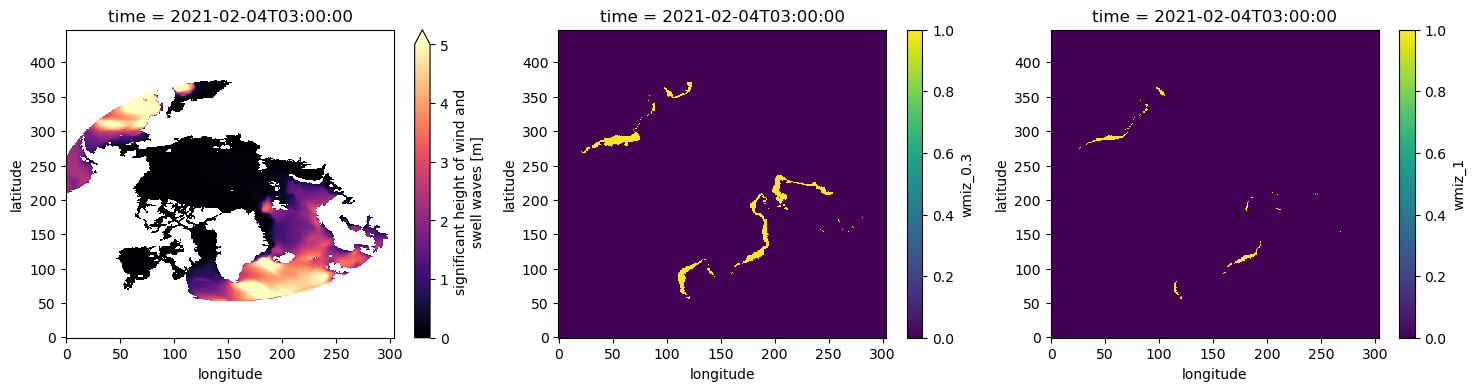

In [37]:
fig = plt.figure(figsize=(18,4))

tt=25

ax = fig.add_subplot(131)
## Plot a quick snapshot
ds_ww3['hs'].isel(time=tt).plot(cmap="magma",vmin=0,vmax=5)

hs_threshold_list = [0.3 , 1]
for ii, hs_threshold in enumerate(hs_threshold_list) :
    ds_ww3[f"wmiz_{hs_threshold}"] = xr.where( (ds_ww3['hs']>hs_threshold)  & (ds_ww3['ice']>0.15), 1,0 )
    ax = fig.add_subplot(1,3,ii+2)
    ds_ww3[f"wmiz_{hs_threshold}"].isel(time=tt).plot()



Text(0, 0.5, 'MIZ extent [km$^2$]')

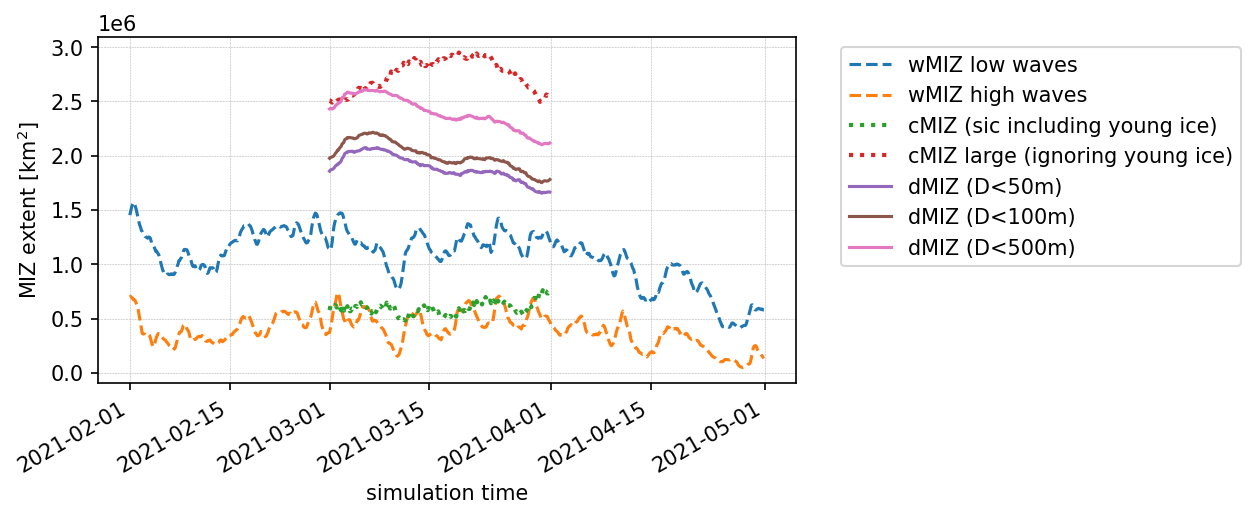

In [47]:
### And we can also compute the timeseries, as we had done for cMIZ and dMIZ-
wmiz_low_area_sum = (ds_ww3["wmiz_0.3"]*grid_area_ww3_da).sum(dim=("latitude", "longitude"))
wmiz_high_area_sum = (ds_ww3["wmiz_1"]*grid_area_ww3_da).sum(dim=("latitude", "longitude"))

#wmiz_area_sum = (ds_ww3["wmiz_1"]*grid_area_ww3_da).sum(dim=("latitude", "longitude"))

fig = plt.figure(figsize=(6,3),dpi=150)
wmiz_low_area_sum.plot(label="wMIZ low waves",ls="--")
wmiz_high_area_sum.plot(label="wMIZ high waves",ls="--")

cmiz_area_sum.plot(label="cMIZ (sic including young ice)",ls=":",lw=2)
cmiz_large_area_sum.plot(label="cMIZ large (ignoring young ice)",ls=":",lw=2)

dmiz_50_area_sum.plot(label="dMIZ (D<50m)")
dmiz_100_area_sum.plot(label="dMIZ (D<100m)")
dmiz_500_area_sum.plot(label="dMIZ (D<500m)")

format_timeseries()
### better to move the legend
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.ylabel(r"MIZ extent [km$^2$]")

#### What a mess!!! 

## Aligning & comparing datasets

It's nice to plot all time series on the same figure, but it could be even nicer to compare the outputs from the two different datasets by showing maps of differences at a given time $t$. Aligning datasets can be a good way to ease the process.

In [54]:
### Rename spatial dimensions to match
ds_ww3_renamed = ds_ww3.rename({'longitude': 'x', 'latitude': 'y'})
### Keep only the times that overlap between the two datasets
ds_nxm_aligned, ds_ww3_aligned = xr.align(ds_nxm,ds_ww3_renamed,join="inner")

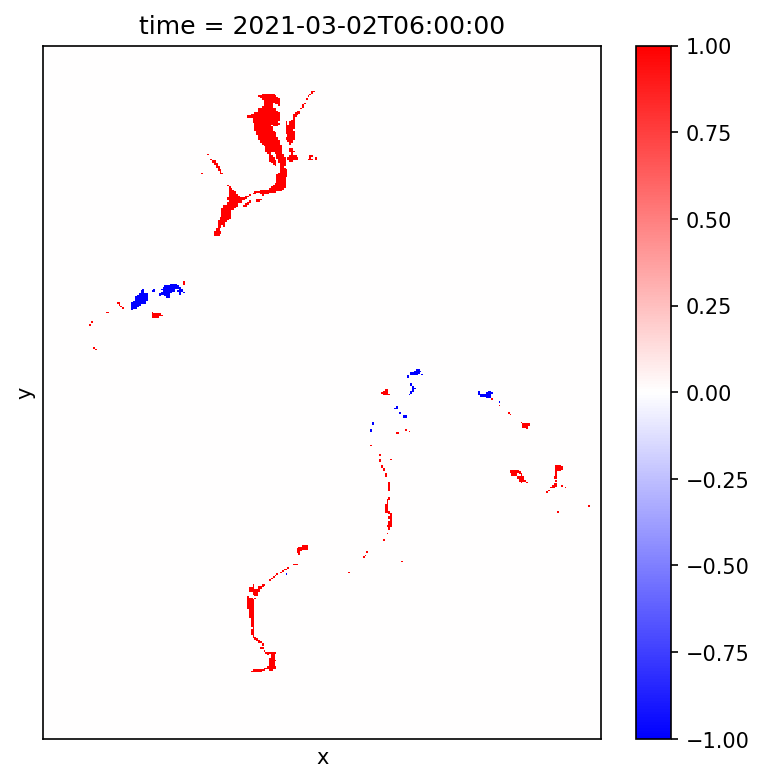

In [57]:
tt=10
fig = plt.figure(figsize=(6,6),dpi=150)
ax=fig.add_subplot(111)
(ds_nxm_aligned["dmiz_100"].isel(time=tt)-ds_ww3_aligned["wmiz_0.3"]).isel(time=tt).plot(cmap="bwr")
format_map(ax)

# To go further

This simulation does not include feedback of waves on sea ice volume and area evolution, but there is still a number of things we can do with it!
One of the main gaps in knowledge is "How far do waves travel in ice?". It mostly depends on what drives their attenuation, and this remains largely misunderstood. This is crucial because this quantity (which is basically the MIZ extent) is by far the main driver of potential wave impact on ice. This makes sense: even if waves have a large impact locally on sea ice, this impact can only be significant at a large scale if the MIZ extent represents a substantial fraction of Arctic sea ice. Beyond the magnitude of the wMIZ/dMIZ extent, it is also interesting to study its discrepancies with the cMIZ extent. Indeed, sea ice models use the concentration as a proxy for the mechanical state of sea ice, and generally assume that ice with a concentration lower than 80% has very low internal stress (as if it was fragmented). Does this threshold ring a bell? The question is: How sensible is it to use the sea ice concentration as proxy for fragmented sea ice?

I am sure there are also plenty of other questions that could be asked; these are my suggestions that follow my obsessions. Feel free to ask me now or later about what could be possible with the model if you think something is missing. 

A few datasets and references of interest (there are many many more!):



(Beware it is **heavily** biased towards the studies and people I am familiar with, it is **not** an objective representation of the field.)

### In-situ wave data:

  "Norwegian buoys" (OMB):
  https://github.com/jerabaul29/data_release_sea_ice_drift_waves_in_ice_marginal_ice_zone_2022/tree/master/Data


  Swift buoys (Seattle team):

  
  https://faculty.washington.edu/jmt3rd/SWIFTdata/DynamicDataLinks.html
  
  https://github.com/SASlabgroup


  I believe there are also 2 AWAC on Moorings in the Beaufort Sea (I believe they belong to WHOI...)
  

### Satellite waves and ice data:

Ardhuin, F., Collard, F., Chapron, B., Girard-Ardhuin, F., Guitton, G., Mouche, A., & Stopa, J. E. (2015). Estimates of ocean wave heights and attenuation in sea ice using the SAR wave mode on Sentinel-1A. Geophysical Research Letters, 42(7), 2014GL062940. https://doi.org/10.1002/2014GL062940

Boutin, G., Williams, T., Horvat, C., & Brodeau, L. (2022). Modelling the Arctic wave-affected marginal ice zone: A comparison with ICESat-2 observations. Philosophical Transactions of the Royal Society A: Mathematical, Physical and Engineering Sciences, 380(2235), 20210262. https://doi.org/10.1098/rsta.2021.0262

Collard, F., Marié, L., Nouguier, F., Kleinherenbrink, M., Ehlers, F., & Ardhuin, F. (2022). Wind-Wave Attenuation in Arctic Sea Ice: A Discussion of Remote Sensing Capabilities. Journal of Geophysical Research: Oceans, 127(7), e2022JC018654. https://doi.org/10.1029/2022JC018654

Hell, M. C., & Horvat, C. (2024). A method for constructing directional surface wave spectra from ICESat-2 altimetry. The Cryosphere, 18(1), 341–361. https://doi.org/10.5194/tc-18-341-2024

Horvat, C., Blanchard-Wrigglesworth, E., & Petty, A. (2020). Observing Waves in Sea Ice With ICESat-2. Geophysical Research Letters, 47(10), e2020GL087629. https://doi.org/10.1029/2020GL087629

Horvat, C., Roach, L., Tilling, R., Bitz, C., Fox-Kemper, B., Guider, C., Hill, K., Ridout, A., & Sheperd, A. (2019). Estimating The Sea Ice Floe Size Distribution Using Satellite Altimetry: Theory, Climatology, and Model Comparison. The Cryosphere Discussions, 1–25. https://doi.org/10.5194/tc-2019-134

### Wave attenuation in ice:

Ardhuin, F., Boutin, G., Stopa, J., Girard-Ardhuin, F., Melsheimer, C., Thomson, J., Kohout, A., Doble, M., & Wadhams, P. (2018). Wave Attenuation Through an Arctic Marginal Ice Zone on 12 October 2015: 2. Numerical Modeling of Waves and Associated Ice Breakup. Journal of Geophysical Research: Oceans, 123(8), 5652–5668. https://doi.org/10.1002/2018JC013784

Boutin, G., Ardhuin, F., Dumont, D., Sévigny, C., Girard-Ardhuin, F., & Accensi, M. (2018). Floe Size Effect on Wave-Ice Interactions: Possible Effects, Implementation in Wave Model, and Evaluation. Journal of Geophysical Research: Oceans, 123(7), 4779–4805. https://doi.org/10.1029/2017JC013622

Cooper, V. T., Roach, L. A., Thomson, J., Brenner, S. D., Smith, M. M., Meylan, M. H., & Bitz, C. M. (2022). Wind waves in sea ice of the western Arctic and a global coupled wave-ice model. Philosophical Transactions of the Royal Society A: Mathematical, Physical and Engineering Sciences, 380(2235), 20210258. https://doi.org/10.1098/rsta.2021.0258

Thomson, J., Fan, Y., Stammerjohn, S., Stopa, J., Rogers, W. E., Girard-Ardhuin, F., Ardhuin, F., Shen, H., Perrie, W., Shen, H., Ackley, S., Babanin, A., Liu, Q., Guest, P., Maksym, T., Wadhams, P., Fairall, C., Persson, O., Doble, M., … Bidlot, J.-R. (2016). Emerging trends in the sea state of the Beaufort and Chukchi seas. Ocean Modelling, 105, 1–12. https://doi.org/10.1016/j.ocemod.2016.02.009

Thomson Jim, Ackley Stephen, Girard‐Ardhuin Fanny, Ardhuin Fabrice, Babanin Alex, Boutin Guillaume, Brozena John, Cheng Sukun, Collins Clarence, Doble Martin, Fairall Chris, Guest Peter, Gebhardt Claus, Gemmrich Johannes, Graber Hans C., Holt Benjamin, Lehner Susanne, Lund Björn, Meylan Michael H., … Wadhams Peter. (2018). Overview of the Arctic Sea State and Boundary Layer Physics Program. Journal of Geophysical Research: Oceans, 123, 8674–8687. https://doi.org/10.1002/2018JC013766


Wadhams, P., Squire, V. A., Ewing, J. A., & Pascal, R. W. (1986). The Effect of the Marginal Ice Zone on the Directional Wave Spectrum of the Ocean. Journal of Physical Oceanography, 16(2), 358–376. https://doi.org/10.1175/1520-0485(1986)016<0358:TEOTMI>2.0.CO;2


### Impact of waves on sea ice:

Bateson, A. W., Feltham, D. L., Schröder, D., Hosekova, L., Ridley, J. K., & Aksenov, Y. (2020). Impact of sea ice floe size distribution on seasonal fragmentation and melt of Arctic sea ice. The Cryosphere, 14(2), 403–428. https://doi.org/10.5194/tc-14-403-2020

Bateson, A. W., Feltham, D. L., Schröder, D., Wang, Y., Hwang, B., Ridley, J. K., & Aksenov, Y. (2022). Sea ice floe size: Its impact on pan-Arctic and local ice mass and required model complexity. The Cryosphere, 16(6), 2565–2593. https://doi.org/10.5194/tc-16-2565-2022

Blanchard‐Wrigglesworth, E., Brenner, S., Webster, M., Horvat, C., Foss, Ø., & Bitz, C. M. (2024). Model Biases in Simulating Extreme Sea Ice Loss Associated With the Record January 2022 Arctic Cyclone. Journal of Geophysical Research: Oceans, 129(8), e2024JC021127. https://doi.org/10.1029/2024JC021127

Blanchard-Wrigglesworth, E., Webster, M., Boisvert, L., Parker, C., & Horvat, C. (2022). Record Arctic Cyclone of January 2022: Characteristics, Impacts, and Predictability. Journal of Geophysical Research: Atmospheres, 127(21), e2022JD037161. https://doi.org/10.1029/2022JD037161

Boutin, G., Lique, C., Ardhuin, F., Rousset, C., Talandier, C., Accensi, M., & Girard-Ardhuin, F. (2020). Towards a coupled model to investigate wave–sea ice interactions in the Arctic marginal ice zone. The Cryosphere, 14(2), 709–735. https://doi.org/10.5194/tc-14-709-2020

Boutin, G., Williams, T., Rampal, P., Olason, E., & Lique, C. (2021). Wave–sea-ice interactions in a brittle rheological framework. The Cryosphere, 15(1), 431–457. https://doi.org/10.5194/tc-15-431-2021

Brenner, S., & Horvat, C. (2024). Scaling Simulations of Local Wind-Waves Amid Sea Ice Floes. Journal of Geophysical Research: Oceans, 129(12), e2024JC021629. https://doi.org/10.1029/2024JC021629

Brenner, S., Horvat, C., Hall, P., Lo Piccolo, A., Fox-Kemper, B., Labbé, S., & Dansereau, V. (2023). Scale-Dependent Air-Sea Exchange in the Polar Oceans: Floe-Floe and Floe-Flow Coupling in the Generation of Ice-Ocean Boundary Layer Turbulence. Geophysical Research Letters, 50(23), e2023GL105703. https://doi.org/10.1029/2023GL105703

Smith, M., Stammerjohn, S., Persson, O., Rainville, L., Liu, G., Perrie, W., Robertson, R., Jackson, J., & Thomson, J. (2018). Episodic Reversal of Autumn Ice Advance Caused by Release of Ocean Heat in the Beaufort Sea. Journal of Geophysical Research: Oceans, 123(5), 3164–3185. https://doi.org/10.1002/2018JC013764

Smith, M., & Thomson, J. (2019). Ocean Surface Turbulence in Newly Formed Marginal Ice Zones. Journal of Geophysical Research: Oceans, 124(3), 1382–1398. https://doi.org/10.1029/2018JC014405

Sutherland, P., & Dumont, D. (2018). Marginal ice zone thickness and extent due to wave radiation stress. Journal of Physical Oceanography. https://doi.org/10.1175/JPO-D-17-0167.1

Vichi, M., Eayrs, C., Alberello, A., Bekker, A., Bennetts, L., Holland, D., Jong, E. de, Joubert, W., MacHutchon, K., Messori, G., Mojica, J. F., Onorato, M., Saunders, C., Skatulla, S., & Toffoli, A. (2019). Effects of an Explosive Polar Cyclone Crossing the Antarctic Marginal Ice Zone. Geophysical Research Letters, 46(11), 5948–5958. https://doi.org/10.1029/2019GL082457


Williams, T. D., Rampal, P., & Bouillon, S. (2017). Wave–ice interactions in the neXtSIM sea-ice model. The Cryosphere, 11(5), 2117–2135. https://doi.org/10.5194/tc-11-2117-2017

